# Import libraries and files

In [1]:
import pickle
from dPCA import dPCA
import multirecording_spikeanalysis as spike
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import sklearn
from sklearn.decomposition import PCA

c:\Users\megha\anaconda3\envs\ephys_analysis\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def pickle_this(thing_to_pickle, file_name):
    with open(file_name,'wb') as file:
        pickle.dump(thing_to_pickle, file)

def unpickle_this(pickle_file):
    with open(pickle_file, 'rb') as file:
        return pickle.load(file)

# Phase 2: Freely moving

Each recording is an ephysrecording instance; the documentation is as follows: 

A class for an ephys recording after being spike sorted and manually
curated using phy. Ephys recording must have a phy folder.


    Attributes:
        path: str, relative path to the phy folder
            formatted as: './folder/folder/phy'
        subject: str, subject id who was being recorded
        event_dict: dict, start and stop times for events
            keys: str, name of event types
            values: np.array, d =(n,2), each 2D array is the start and stop time 
            in ms for each event, n = number of events of type key
        sampling_rate: int, sampling rate of the ephys device
            in Hz, standard in the PC lab is 20,000Hz
        timestamps_var: numpy array, all spike timestamps
            of good and mua units (no noise unit-generated spikes)
        unit_array: numpy array, unit ids associated with each
            spike in the timestamps_var
        labels_dict: dict, keys are unit ids (str) and
            values are labels (str)
        unit_timestamps: dict, keys are unit ids (int), and
            values are numpy arrays of timestamps for all spikes
            from "good" units only
        spiketrain: np.array, spiketrain of number of spikes
            in a specified timebin
        unit_spiketrains: dict, spiketrains for each unit
            keys: str, unit ids
            values: np.array, number of spikes per specified timebin
        unit_firing_rates: dict, firing rates per unit
            keys: str, unit ids
            values: np.arrays, firing rate of unit in a specified timebin
                    calculated with a specified smoothing window

    Methods: (all called in __init__)
        get_unit_labels: creates labels_dict
        get_spike_specs: creates timestamps_var and unit_array
        get_unit_timestamps: creates unit_timestamps dictionary


All recordings have been put into an instance of the class type ephysrecordingcollection.
Big picture is that phase2_collection has an attribute called collection which is a dictionary of 
recording names: recording objects. 

In [3]:
phase2_collection = unpickle_this('phase2collection.pkl')

In [4]:
is_first = True
for recording_name, recording in phase2_collection.collection.items():
    print(recording.event_dict['recall'][0])
    print(recording.event_dict['novel'][0])
    if is_first:
        print('Example recording:')
        print(recording_name)
        print("")
        print('Event Types:')
        print(recording.event_dict.keys())
        print(recording.event_dict['recall'])
        print(recording.event_dict['novel'][0])
        print("")
        print('Number of units:')
        print(len(recording.unit_timestamps.keys()))
        is_first = False

[1237154.35 1238354.35]
[1832021.35 1837154.35]
Example recording:
20230803_101331_1_merged.rec

Event Types:
dict_keys(['acquisition', 'recall', 'cagemate', 'novel', 'exposure 0', 'exposure 1', 'exposure 2', 'exposure 3', 'iti', 'iti_events'])
[[1237154.35 1238354.35]
 [1244821.35 1253821.35]
 [1293921.35 1296488.35]
 [1515854.35 1518721.35]]
[1832021.35 1837154.35]

Number of units:
52
[1543718.3 1545384.3]
[1243918.3 1246084.3]
[1807333. 1811133.]
[1526900. 1528133.]
[1207600. 1210433.]
[1808033. 1812867.]
[1517100. 1518800.]
[1218933. 1220433.]
[1832133. 1859433.]
[1532400. 1554467.]
[1207767. 1216533.]
[1824467. 1826333.]
[1599697.4 1601063.4]
[1295030.4 1300729.4]
[1807033. 1808833.]
[1510367. 1517767.]


In [5]:
phase2_collection.collection.items()

dict_items([('20230803_101331_1_merged.rec', <multirecording_spikeanalysis.EphysRecording object at 0x000001F1FF1E2020>), ('20230803_121318_1_merged.rec', <multirecording_spikeanalysis.EphysRecording object at 0x000001F18C6E3100>), ('20230803_141047_1_merged.rec', <multirecording_spikeanalysis.EphysRecording object at 0x000001F192F2ED70>), ('20230804_121600_1_merged.rec', <multirecording_spikeanalysis.EphysRecording object at 0x000001F19037AA40>), ('20230804_141009_1_merged.rec', <multirecording_spikeanalysis.EphysRecording object at 0x000001F1A0327CA0>), ('20230817_100823_1_merged.rec', <multirecording_spikeanalysis.EphysRecording object at 0x000001F1A4C7C490>), ('20230817_113746_1_merged.rec', <multirecording_spikeanalysis.EphysRecording object at 0x000001F19884EBF0>), ('20230818_115728_1_merged.rec', <multirecording_spikeanalysis.EphysRecording object at 0x000001F1AFE44580>), ('20230818_133620_1_merged.rec', <multirecording_spikeanalysis.EphysRecording object at 0x000001F1B3CDD450>)

Here is another class I made for spike analysis specifically. 

Parameters that you should feel free to play with are smoothin_window and timebin (both in ms).

    Timebin:
        window for each element in all the arrays (spiketrains, firing rates, etc.).
    Smoothing window:
        the rolling average window size to be used when calculating firing rates. 

In [104]:
# PCA analysis parameters
phase2_analysis = spike.SpikeAnalysis_MultiRecording(
    phase2_collection,
    smoothing_window = 500,
    timebin = 50,
    ignore_freq = 0.5)

All set to analyze


## Create trialed dataset for dPCA analysis
Use only one recording and one subject for the analysis.

In [105]:
recordings = phase2_analysis.ephyscollection.collection.items()
equalize = 3 ; pre_window = 3; post_window = 0
events = ['recall', 'cagemate', 'novel']
for recording_name, recording in recordings:

    if (recording.subject != '1.4') or (recording_name != '20230804_121600_1_merged.rec'):
        continue

    print(recording_name)
    print(recording.subject)

    first_event = True
    temp_spike_events = []
    temp_avg_events = []
    for event in events:
        if first_event:
            event_firing_rates = phase2_analysis.__get_event_firing_rates__(recording, event, equalize, pre_window, post_window)
            event_firing_rates = np.array(event_firing_rates)
            event_averages = np.mean(event_firing_rates, axis = 0)
            temp_avg_events.append(np.reshape(event_averages, (event_averages.shape[0], 1, event_averages.shape[1])))
            all_event_firing_rates = np.reshape(event_firing_rates, (event_firing_rates.shape[0], event_firing_rates.shape[1], 1, event_firing_rates.shape[2]))
            first_event = False
        else:
            event_firing_rates = phase2_analysis.__get_event_firing_rates__(recording, event, equalize, pre_window, post_window)
            event_firing_rates = np.array(event_firing_rates)
            event_averages = np.mean(event_firing_rates, axis = 0) 
            temp_avg_events.append(np.reshape(event_averages, (event_averages.shape[0], 1, event_averages.shape[1])))
            event_firing_rates_reshape = np.reshape(event_firing_rates, (event_firing_rates.shape[0], event_firing_rates.shape[1], 1, event_firing_rates.shape[2]))
            all_event_firing_rates = np.concatenate((all_event_firing_rates, event_firing_rates_reshape), axis=0)
        temp_spike_events.append(all_event_firing_rates[:7])
        # break
    comb_trials = np.concatenate((temp_spike_events[0], temp_spike_events[1], temp_spike_events[2]), axis=2)
    print(comb_trials.shape)
    comb_avgtrials = np.concatenate((temp_avg_events[0], temp_avg_events[1], temp_avg_events[2]), axis=1)
    print(comb_avgtrials.shape)
    break

20230804_121600_1_merged.rec
1.4
(7, 28, 3, 120)
(28, 3, 120)


## Visualize differences in spiking for a single subject and recording

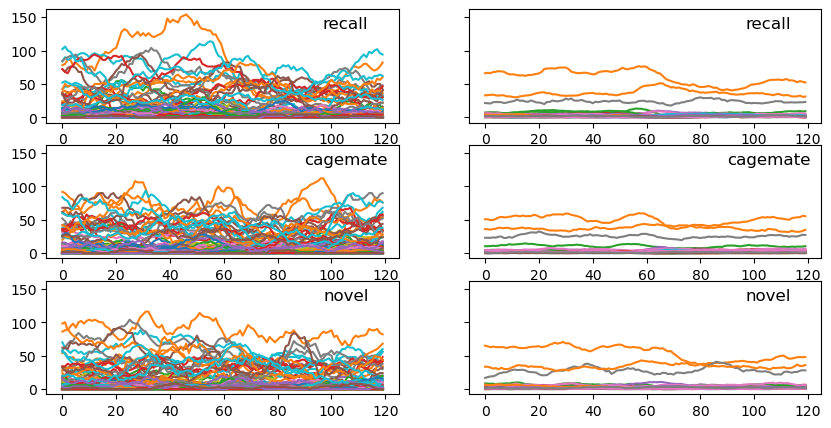

In [106]:
recordings = phase2_analysis.ephyscollection.collection.items()
equalize = 3 ; pre_window = 3; post_window = 0
events = ['recall', 'cagemate', 'novel']
colors = ['r', 'b', 'g', 'm', 'c', 'pink', 'purple']

fig, ax = plt.subplots(3, 2, figsize=(10, 5), sharey=True)

for recording_name, recording in recordings:

    if (recording.subject != '1.4') or (recording_name != '20230804_121600_1_merged.rec'):
        continue

    # print(recording_name)
    # print(recording.subject)

    first_event = True
    temp_spike_events = []
    temp_avg_events = []
    idx = 0
    for event in events:
    
        if first_event:
            event_firing_rates = phase2_analysis.__get_event_firing_rates__(recording, event, equalize, pre_window, post_window)
            event_firing_rates = np.array(event_firing_rates)
            event_averages = np.mean(event_firing_rates, axis = 0)
            for i in range(7):
                for j in range(event_firing_rates[i].shape[0]):
                    ax[idx,0].plot(np.arange(event_firing_rates[i].shape[1]), event_firing_rates[i][j])
            ax[idx,0].set_title(str(event), x=.85, y=1, pad=-14)
            for i in range(event_averages.shape[0]):
                ax[idx,1].plot(np.arange(event_averages.shape[1]), event_averages[i])
            ax[idx,1].set_title(str(event), x=.85, y=1, pad=-14)
            temp_avg_events.append(np.reshape(event_averages, (event_averages.shape[0], 1, event_averages.shape[1])))
            all_event_firing_rates = np.reshape(event_firing_rates, (event_firing_rates.shape[0], event_firing_rates.shape[1], 1, event_firing_rates.shape[2]))
            first_event = False
        else:
            event_firing_rates = phase2_analysis.__get_event_firing_rates__(recording, event, equalize, pre_window, post_window)
            event_firing_rates = np.array(event_firing_rates)
            event_averages = np.mean(event_firing_rates, axis = 0) 
            for i in range(7):
                for j in range(event_firing_rates[i].shape[0]):
                    ax[idx,0].plot(np.arange(event_firing_rates[i].shape[1]), event_firing_rates[i][j])
            ax[idx,0].set_title(str(event), x=.85, y=1, pad=-14)
            for i in range(event_averages.shape[0]):
                ax[idx,1].plot(np.arange(event_averages.shape[1]), event_averages[i])
            ax[idx,1].set_title(str(event), x=.85, y=1, pad=-14)
            temp_avg_events.append(np.reshape(event_averages, (event_averages.shape[0], 1, event_averages.shape[1])))
            event_firing_rates_reshape = np.reshape(event_firing_rates, (event_firing_rates.shape[0], event_firing_rates.shape[1], 1, event_firing_rates.shape[2]))
            all_event_firing_rates = np.concatenate((all_event_firing_rates, event_firing_rates_reshape), axis=0)
        temp_spike_events.append(all_event_firing_rates[:7])
        idx += 1
        # break
    comb_trials = np.concatenate((temp_spike_events[0], temp_spike_events[1], temp_spike_events[2]), axis=2)
    comb_avgtrials = np.concatenate((temp_avg_events[0], temp_avg_events[1], temp_avg_events[2]), axis=1)
    break

## Perform dPCA on trialed data

In [107]:
print(comb_avgtrials.shape)
print(comb_trials.shape)


(28, 3, 120)
(7, 28, 3, 120)


In [108]:
dpca = dPCA.dPCA('st', n_components=5, regularizer='auto')
dpca.protect = ['t']
dpca_comb = dpca.fit_transform(comb_avgtrials, comb_trials)

You chose to determine the regularization parameter automatically. This can
                    take substantial time and grows linearly with the number of crossvalidation
                    folds. The latter can be set by changing self.n_trials (default = 3). Similarly,
                    use self.protect to set the list of axes that are not supposed to get to get shuffled
                    (e.g. upon splitting the data into test- and training, time-points should always
                    be drawn from the same trial, i.e. self.protect = ['t']). This can significantly
                    speed up the code.
Start optimizing regularization.
Starting trial  1 / 3


Starting trial  2 / 3
Starting trial  3 / 3
Optimized regularization, optimal lambda =  0.003388200529767837
Regularization will be fixed; to compute the optimal                    parameter again on the next fit, please                    set opt_regularizer_flag to True.


0.06516607854246981
0.0067803922557556065
0.003556761516613108


Text(0.5, 0.98, 'Explained cumulative variance')

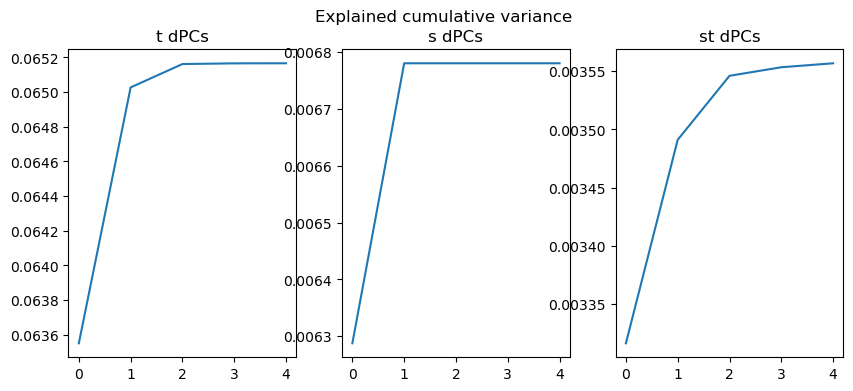

In [109]:
# PLot the explained cumulative variances for the time, stimulus, and time+stimulus components
fig = plt.figure(figsize=(10,4))
plt.subplot(131)
plt.plot(np.cumsum(dpca.explained_variance_ratio_['t']))
print(np.sum(dpca.explained_variance_ratio_['t']))
plt.title("t dPCs")

plt.subplot(132)
plt.plot(np.cumsum(dpca.explained_variance_ratio_['s']))
print(np.sum(dpca.explained_variance_ratio_['s']))
plt.title("s dPCs")

plt.subplot(133)
plt.plot(np.cumsum(dpca.explained_variance_ratio_['st']))
print(np.sum(dpca.explained_variance_ratio_['st']))
plt.title("st dPCs")

plt.suptitle("Explained cumulative variance")

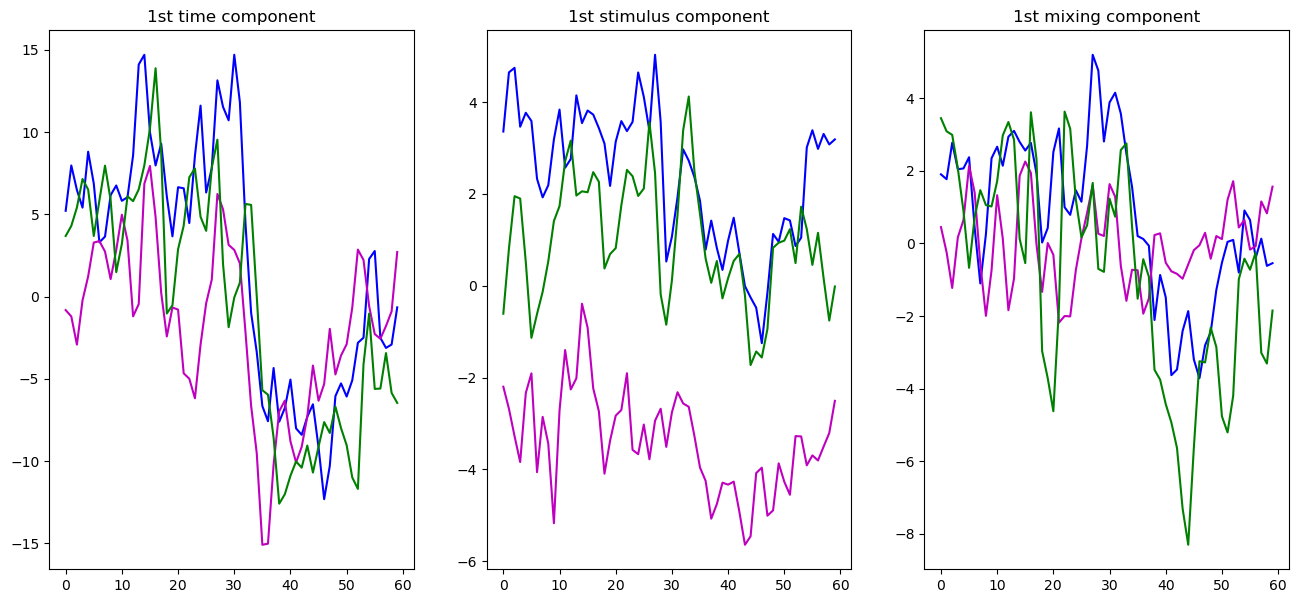

In [12]:
# Plot the time, stimlus, and mixed components
time = np.arange(comb_avgtrials.shape[2])
S = comb_avgtrials.shape[1]
colors = ['b', 'm', 'g']

plt.figure(figsize=(16,7))
plt.subplot(131)

for s in range(S):
    plt.plot(time,dpca_comb['t'][0,s], color=colors[s])

plt.title('1st time component')
    
plt.subplot(132)

for s in range(S):
    plt.plot(time,dpca_comb['s'][0,s], color=colors[s])
    
plt.title('1st stimulus component')
    
plt.subplot(133)

for s in range(S):
    plt.plot(time,dpca_comb['st'][0,s], color=colors[s])
    
plt.title('1st mixing component')
plt.show()

In [13]:
# Determine whether any components are significant
significance_masks = dpca.significance_analysis(comb_avgtrials, comb_trials, n_shuffles=10, n_splits=10, n_consecutive=10)

Compute score of data:  . . . . . . . . . . Finished.
Compute score of shuffled data:  9 / 10 . . . . . . . . . . . . . 

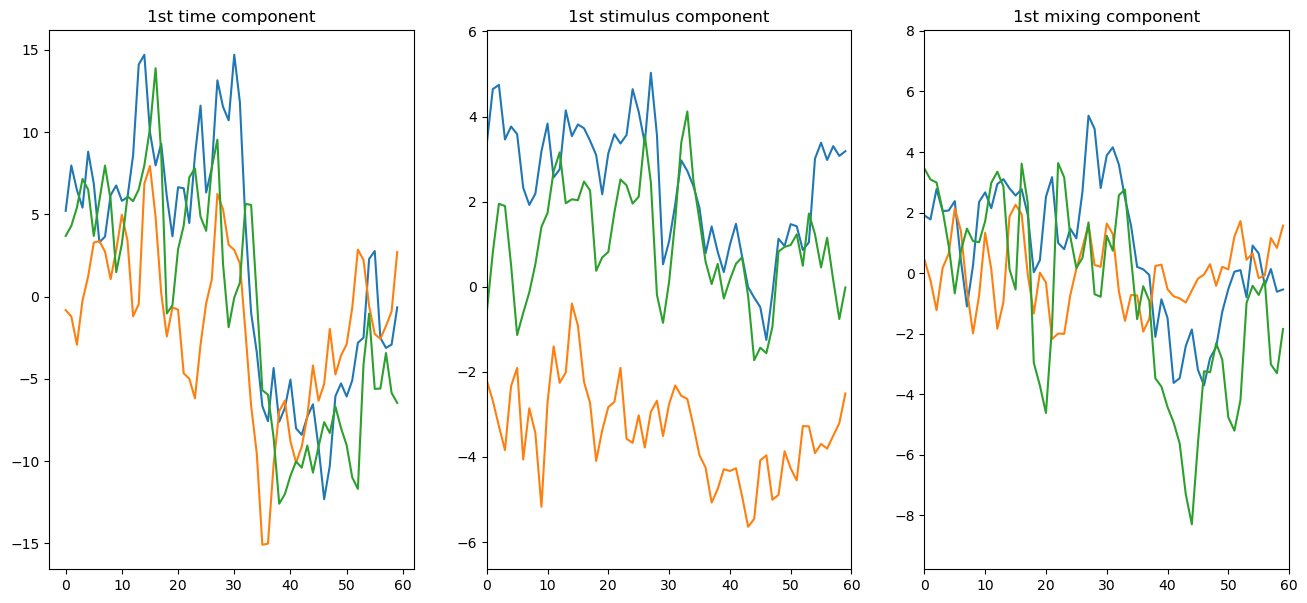

In [14]:
# Display components with significance mask (black line on plot)
time = np.arange(comb_avgtrials.shape[2])
S = comb_avgtrials.shape[1]

plt.figure(figsize=(16,7))
plt.subplot(131)

for s in range(S):
    plt.plot(time,dpca_comb['t'][0,s])

plt.title('1st time component')
    
plt.subplot(132)

for s in range(S):
    plt.plot(time,dpca_comb['s'][0,s])

plt.imshow(significance_masks['s'][0][None,:],extent=[0,len(time),np.amin(dpca_comb['s'])-1,np.amin(dpca_comb['s'])-0.5],aspect='auto',cmap='gray_r',vmin=0,vmax=1)
plt.ylim([np.amin(dpca_comb['s'])-1,np.amax(dpca_comb['s'])+1])

plt.title('1st stimulus component')
    
plt.subplot(133)

for s in range(S):
    plt.plot(time,dpca_comb['st'][0,s])

dZ = np.amax(dpca_comb['st'])-np.amin(dpca_comb['st'])
plt.imshow(significance_masks['st'][0][None,:],extent=[0,len(time),np.amin(dpca_comb['st'])-dZ/10.,np.amin(dpca_comb['st'])-dZ/5.],aspect='auto',cmap='gray_r',vmin=0,vmax=1)
plt.ylim([np.amin(dpca_comb['st'])-dZ/10.,np.amax(dpca_comb['st'])+dZ/10.])
    
plt.title('1st mixing component')
plt.show()

In [15]:
comb_avgtrials.shape

(28, 3, 60)

## Perform dPCA on averaged data

In [16]:
events = list(recording.event_dict.keys())
events

['acquisition',
 'recall',
 'cagemate',
 'novel',
 'exposure 0',
 'exposure 1',
 'exposure 2',
 'exposure 3',
 'iti',
 'iti_events']

### Define familiarity conditions

In [17]:
tester_analysis = spike.SpikeAnalysis_MultiRecording(
    phase2_collection,
    smoothing_window = 500,
    timebin = 50,
    ignore_freq = 0.5)
pc_dict = tester_analysis.PCA_matrix_generation(equalize=3, pre_window=3, events=['novel', 'acquisition','cagemate', 'recall'])

All set to analyze


In [18]:
LT_pc_dict = phase2_analysis.PCA_matrix_generation(equalize=3, pre_window=3, events=['cagemate'])
ST_pc_dict = phase2_analysis.PCA_matrix_generation(equalize=3, pre_window=3, events=['recall'])
acq_pc_dict = phase2_analysis.PCA_matrix_generation(equalize=3, pre_window=3, events=['acquisition'])
novel_pc_dict = phase2_analysis.PCA_matrix_generation(equalize=3, pre_window=3, events=['novel'])
#dict_keys(['acquisition', 'recall', 'cagemate', 'novel', 'exposure 1', 'exposure 2', 'exposure 3'])
LT_matrix_phase2 = LT_pc_dict['raw data']
ST_matrix_phase2 = ST_pc_dict['raw data']
acq_matrix_phase2 = acq_pc_dict['raw data']
novel_matrix_phase2 = novel_pc_dict['raw data']

In [19]:
n_components = 10

In [115]:
for recording_name, recording in phase2_collection.collection.items():
    print(recording_name)

20230803_101331_1_merged.rec
20230803_121318_1_merged.rec
20230803_141047_1_merged.rec
20230804_121600_1_merged.rec
20230804_141009_1_merged.rec
20230817_100823_1_merged.rec
20230817_113746_1_merged.rec
20230818_115728_1_merged.rec
20230818_133620_1_merged.rec


In [160]:
#we need 83 of each since recall only has 83
equalize = 3 ; pre_window = 3; post_window = 0
events = ['recall', 'cagemate', 'novel']
event_frequency = {event: 0 for event in events}
recording_event_frequency = {recording: {event: 0 for event in events} 
                                         for recording in phase2_collection.collection.keys()}
temp_spike_events = []
temp_avg_events = []
avg_events = {}
spike_events = {}
for event in events:
    for recording_name, recording in phase2_collection.collection.items():
        event_firing_rates = phase2_analysis.__get_event_firing_rates__(recording, event, equalize, pre_window, post_window)
        event_firing_rates = np.array(event_firing_rates)
        #[trials, neruons, timebins]
        event_averages = np.mean(event_firing_rates, axis = 0) 
        #[neruons, timebins]
        #temp_avg_events.append(np.reshape(event_averages, (event_averages.shape[0], 1, event_averages.shape[1])))
        #event_firing_rates_reshape = np.reshape(event_firing_rates, (event_firing_rates.shape[0], event_firing_rates.shape[1], 1, event_firing_rates.shape[2]))
        #all_event_firing_rates = np.concatenate((all_event_firing_rates, event_firing_rates_reshape), axis=0)
        event_frequency[event] = event_frequency[event] + len(event_firing_rates)
        recording_event_frequency[recording_name][event] = len(event_firing_rates)
        print(event_firing_rates.shape)
        temp_spike_events.append(event_firing_rates)
        temp_avg_events.append(event_averages)
    temp_spike_events)

for key, value in avg_events.items():
    print(key)
    print(value.shape)
print(event_frequency)
print("")
for recording, frequencies in recording_event_frequency.items():
    print(recording)
    print("")
    print(frequencies)


(4, 18, 120)
(6, 18, 120)
(3, 18, 120)
(6, 19, 120)
(7, 19, 120)
(9, 19, 120)
(13, 32, 120)
(10, 32, 120)
(9, 32, 120)
(11, 28, 120)
(12, 28, 120)
(8, 28, 120)
(8, 28, 120)
(12, 28, 120)
(13, 28, 120)
(20, 21, 120)
(12, 21, 120)
(12, 21, 120)
(7, 22, 120)
(11, 22, 120)
(12, 22, 120)
(8, 17, 120)
(2, 17, 120)
(7, 17, 120)
(6, 30, 120)
(11, 30, 120)
(10, 30, 120)
27
{'recall': 83, 'cagemate': 83, 'novel': 83}

20230803_101331_1_merged.rec

{'recall': 4, 'cagemate': 6, 'novel': 3}
20230803_121318_1_merged.rec

{'recall': 6, 'cagemate': 7, 'novel': 9}
20230803_141047_1_merged.rec

{'recall': 13, 'cagemate': 10, 'novel': 9}
20230804_121600_1_merged.rec

{'recall': 11, 'cagemate': 12, 'novel': 8}
20230804_141009_1_merged.rec

{'recall': 8, 'cagemate': 12, 'novel': 13}
20230817_100823_1_merged.rec

{'recall': 20, 'cagemate': 12, 'novel': 12}
20230817_113746_1_merged.rec

{'recall': 7, 'cagemate': 11, 'novel': 12}
20230818_115728_1_merged.rec

{'recall': 8, 'cagemate': 2, 'novel': 7}
20230818_

In [ ]:
    #comb_trials = np.concatenate((temp_spike_events[0], temp_spike_events[1], temp_spike_events[2]), axis=2)
    #print(comb_trials.shape)
    #comb_avgtrials = np.concatenate((temp_avg_events[0], temp_avg_events[1], temp_avg_events[2]), axis=1)
    #print(comb_avgtrials.shape)




# print(event_frequency)
# print("")
# for recording, frequencies in recording_event_frequency.items():
#     print(recording)
#     print("")
#     print(frequencies)

#i need to get rid of 99-83 = 16 novel sniffs
# i need to get rid of 99-88 = 11 cagemate sniffs
#20230817_100823_1_merged.rec: get rid of 6 cagemates, and 10 novels 
#20230817_113746_1_merged.rec: get rid of 6 novels
#20230804_141009_1_merged.rec: get rid of 2 cagemates
#20230804_121600_1_merged.rec: get rid of 2 cagemate
#20230818_133620_1_merged.rec: get rid of 1 cagemate
# num_objects = len(recording_event_frequency.keys())

# target_cagemate = event_frequency['cagemate'] // num_objects
# target_novel = event_frequency['novel'] // num_objects
# target_recall = event_frequency['recall'] // num_objects

# def sort_outer_keys_by_inner_value(nested_dict, target_key):

#     key_value_pairs = [(outer_key, inner_dict.get(target_key, float('-inf')))
#                        for outer_key, inner_dict in nested_dict.items()]
    
#     # Sort the list of tuples by the target value in descending order
#     sorted_key_value_pairs = sorted(key_value_pairs, key=lambda x: x[1], reverse=True)
    
#     # Extract and return the sorted outermost keys
#     sorted_outer_keys = [outer_key for outer_key, value in sorted_key_value_pairs]

#     return sorted_outer_keys

# sorted_recordings_cagemate = sort_outer_keys_by_inner_value(recording)


# def trim_features(objects, feature, target):
#     for obj in sorted(objects, key=lambda x: -x.get(feature, 0)):
#         if obj[feature] > target:
#             excess = obj[feature] - target
#             obj[feature] -= excess
#             if sum(obj.values()) <= target:
#                 break
# trimmed_frequencies = recording_event_frequency
# trim_features(trimmed_frequencies, 'cagemate', target_recall)
# trim_features(trimmed_frequencies, 'novel', target_recall)


# for recording, frequencies in trimmed_frequencies.items():
#     print("")
#     print(recording)
#     print("")
#     print("before trimming")
#     print(recording_event_frequency[recording])
#     print("")
#     print("after trimming")
#     print(frequencies)

### Create dataset of averaged data

In [65]:
LT_np = LT_matrix_phase2.to_numpy().T
#LT_matrix_phase2 = T x neuron
#LT_np = neurons x timebins
LT_np = np.reshape(LT_np, (LT_np.shape[0], 1, LT_np.shape[1]))

ST_np = ST_matrix_phase2.to_numpy().T
ST_np = np.reshape(ST_np, (ST_np.shape[0], 1, ST_np.shape[1]))

novel_np = novel_matrix_phase2.to_numpy().T
novel_np = np.reshape(novel_np, (novel_np.shape[0], 1, novel_np.shape[1]))

acq_np = acq_matrix_phase2.to_numpy().T
acq_np = np.reshape(acq_np, (acq_np.shape[0], 1, acq_np.shape[1]))

(60, 215)
(215, 60)


In [62]:
print(LT_np.shape)
print(ST_np.shape)
print(acq_np.shape)
print(novel_np.shape)

(176, 1, 24)
(176, 1, 24)
(176, 1, 24)
(176, 1, 24)


### Perform dPCA on LT, ST, and novel averaged data

In [21]:
comb_np = np.concatenate((LT_np, ST_np, novel_np), axis=1)
comb_np.shape

(215, 3, 60)

In [22]:
dpca = dPCA.dPCA('st', n_components=10, regularizer=0.1)
dpca.protect = ['t']
dpca_comb = dpca.fit_transform(comb_np)

2.6745143699123556e-09
2.2222625571761365e-09
3.7169521635500353e-10


Text(0.5, 0.98, 'Explained cumulative variance')

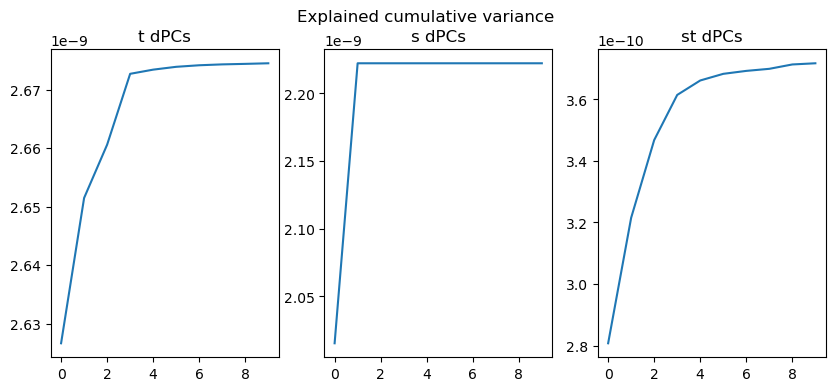

In [23]:
fig = plt.figure(figsize=(10,4))
plt.subplot(131)
plt.plot(np.cumsum(dpca.explained_variance_ratio_['t']))
print(np.sum(dpca.explained_variance_ratio_['t']))
plt.title("t dPCs")

plt.subplot(132)
plt.plot(np.cumsum(dpca.explained_variance_ratio_['s']))
print(np.sum(dpca.explained_variance_ratio_['s']))
plt.title("s dPCs")

plt.subplot(133)
plt.plot(np.cumsum(dpca.explained_variance_ratio_['st']))
print(np.sum(dpca.explained_variance_ratio_['st']))
plt.title("st dPCs")

plt.suptitle("Explained cumulative variance")

In [ ]:
def parametertuner(tbs, sms, els, pws, pcs):    
    parameters = {}
    for tb in tbs:
            print(tb)
            for sm in sms:
                 print(sm)
                 for el in els:
                      for pw in pws:
                            for n_components in pcs:
                                try:
                                    phase2_analysis = spike.SpikeAnalysis_MultiRecording(phase2_collection,
                                                                                    timebin = tb,
                                                                                    ignore_freq = 0.5,
                                                                                    smoothing_window = sm)
                                    LT_pc_dict = phase2_analysis.PCA_matrix_generation(equalize=el, pre_window=pw, events=['cagemate'])
                                    ST_pc_dict = phase2_analysis.PCA_matrix_generation(equalize=el, pre_window=pw, events=['recall'])
                                    acq_pc_dict = phase2_analysis.PCA_matrix_generation(equalize=el, pre_window=pw, events=['acquisition'])
                                    novel_pc_dict = phase2_analysis.PCA_matrix_generation(equalize=el, pre_window=pw, events=['novel'])
                                    #dict_keys(['acquisition', 'recall', 'cagemate', 'novel', 'exposure 1', 'exposure 2', 'exposure 3'])
                                    LT_matrix_phase2 = LT_pc_dict['raw data']
                                    ST_matrix_phase2 = ST_pc_dict['raw data']
                                    acq_matrix_phase2 = acq_pc_dict['raw data']
                                    novel_matrix_phase2 = novel_pc_dict['raw data']
                                    LT_np = LT_matrix_phase2.to_numpy().T
                                    LT_np = np.reshape(LT_np, (LT_np.shape[0], 1, LT_np.shape[1]))

                                    ST_np = ST_matrix_phase2.to_numpy().T
                                    ST_np = np.reshape(ST_np, (ST_np.shape[0], 1, ST_np.shape[1]))

                                    novel_np = novel_matrix_phase2.to_numpy().T
                                    novel_np = np.reshape(novel_np, (novel_np.shape[0], 1, novel_np.shape[1]))

                                    acq_np = acq_matrix_phase2.to_numpy().T
                                    acq_np = np.reshape(acq_np, (acq_np.shape[0], 1, acq_np.shape[1]))
                                    comb_np = np.concatenate((LT_np, ST_np, novel_np), axis=1)
                                    print(comb_np.shape)
                                    if comb_np.shape[1] * comb_np.shape[2] > comb_np.shape[0]:
                                        dpca = dPCA.dPCA('st', n_components, regularizer=0.1)
                                        dpca.protect = ['t']
                                        dpca_comb = dpca.fit_transform(comb_np)
                                        parameters[max(dpca.explained_variance_ratio_['s'])] = {'timebin': tb, 
                                                                                                'smoothing window': sm,
                                                                                                'event length': el,
                                                                                                'pre window': pw,
                                                                                                'pcs': n_components}
                                except Exception as e:
                                     print(e)
                                     
    return(parameters)

#parameter_dict = parametertuner([100], [None], [4], [3], [10])  
#parameter_dict                       
parameter_dict = parametertuner([50,100,150,200,250], [None,100,250,500], [1,2,3,4,5,6,7], [1,2,3,4,5,6,7], [10])

In [58]:
small_parameter_dict = parametertuner([250], [10000], [10], [10], [10])
small_parameter_dict

250
10000
All set to analyze
(215, 3, 80)


{7.998392831789927e-08: {'timebin': 250,
  'smoothing window': 10000,
  'event length': 10,
  'pre window': 10,
  'pcs': 10}}

3.216343574620174e-09
[3.216343574620174e-09, 2.2527795787637934e-09, 2.0191235304654266e-09, 1.774179179294531e-09, 1.414376602883386e-09, 1.307936407886141e-09, 1.1167057894067095e-09, 1.0624491721572573e-09, 1.0357805060406315e-09, 1.0281907221174327e-09]
{'timebin': 50, 'smoothing window': 500, 'event length': 3, 'pre window': 1, 'pcs': 10}
{'timebin': 50, 'smoothing window': 500, 'event length': 4, 'pre window': 1, 'pcs': 10}
{'timebin': 100, 'smoothing window': 500, 'event length': 7, 'pre window': 1, 'pcs': 10}
{'timebin': 100, 'smoothing window': 500, 'event length': 6, 'pre window': 2, 'pcs': 10}
{'timebin': 50, 'smoothing window': 500, 'event length': 5, 'pre window': 1, 'pcs': 10}
{'timebin': 100, 'smoothing window': 500, 'event length': 5, 'pre window': 3, 'pcs': 10}
{'timebin': 100, 'smoothing window': 500, 'event length': 4, 'pre window': 4, 'pcs': 10}
{'timebin': 100, 'smoothing window': 500, 'event length': 6, 'pre window': 3, 'pcs': 10}
{'timebin': 50, 'smoothing windo

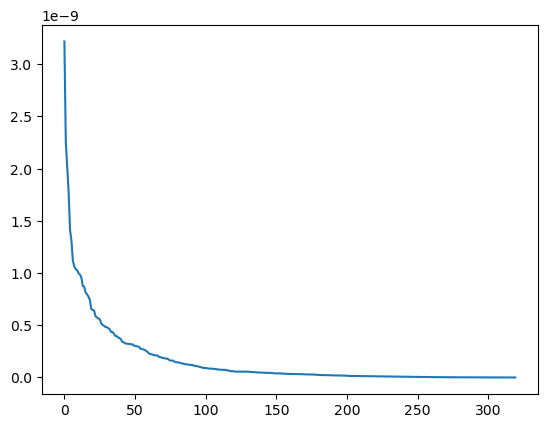

In [60]:
print(max(list(parameter_dict.keys())))
sorted_parameters = sorted(list(parameter_dict.keys()), reverse=True)
print(sorted_parameters[0:10])
plt.plot(sorted_parameters[0:1000])
for i in range(20):
    print(parameter_dict[sorted_parameters[i]])

[6.424810516568664e-10, 6.424810516568662e-10, 6.424810516568661e-10, 6.42481051656866e-10, 6.424810516568659e-10, 6.424810516568658e-10, 6.424810516568657e-10, 6.424810516568656e-10, 6.424810516568655e-10, 6.424810516568654e-10]
{'timebin': 250, 'smoothing window': 500, 'event length': 3, 'pre window': 3, 'pcs': 10}
{'timebin': 250, 'smoothing window': 500, 'event length': 5, 'pre window': 1, 'pcs': 5}
{'timebin': 250, 'smoothing window': 500, 'event length': 5, 'pre window': 5, 'pcs': 5}
{'timebin': 250, 'smoothing window': 500, 'event length': 5, 'pre window': 4, 'pcs': 3}
{'timebin': 250, 'smoothing window': 500, 'event length': 5, 'pre window': 4, 'pcs': 10}
{'timebin': 250, 'smoothing window': 500, 'event length': 5, 'pre window': 5, 'pcs': 8}
{'timebin': 250, 'smoothing window': 500, 'event length': 5, 'pre window': 5, 'pcs': 10}
{'timebin': 250, 'smoothing window': 500, 'event length': 4, 'pre window': 5, 'pcs': 3}
{'timebin': 250, 'smoothing window': 500, 'event length': 5, 'pre window': 5, 'pcs': 2}
{'timebin': 250, 'smoothing window': 500, 'event length': 5, 'pre window': 4, 'pcs': 5}

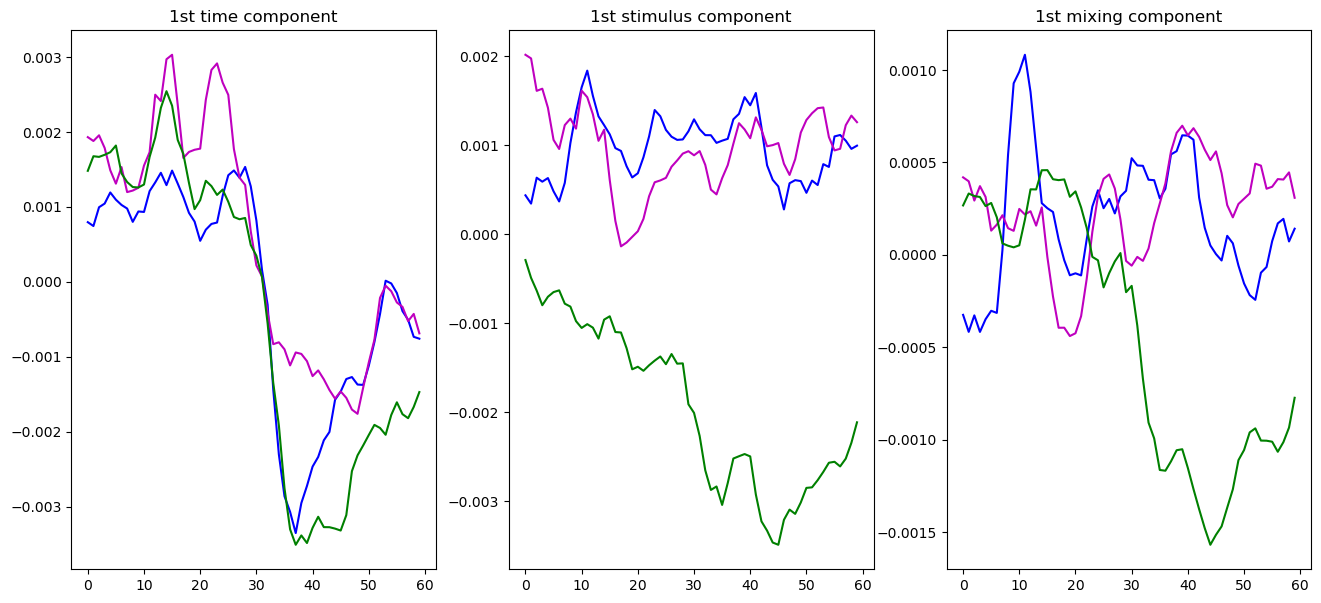

In [27]:
time = np.arange(comb_np.shape[2])
S = comb_np.shape[1]
colors = ['b', 'm', 'g']

plt.figure(figsize=(16,7))
plt.subplot(131)

for s in range(S):
    plt.plot(time,dpca_comb['t'][0,s], color=colors[s])

plt.title('1st time component')
    
plt.subplot(132)

for s in range(S):
    plt.plot(time,dpca_comb['s'][0,s], color=colors[s])
    
plt.title('1st stimulus component')
    
plt.subplot(133)

for s in range(S):
    plt.plot(time,dpca_comb['st'][0,s], color=colors[s])
    
plt.title('1st mixing component')
plt.show()

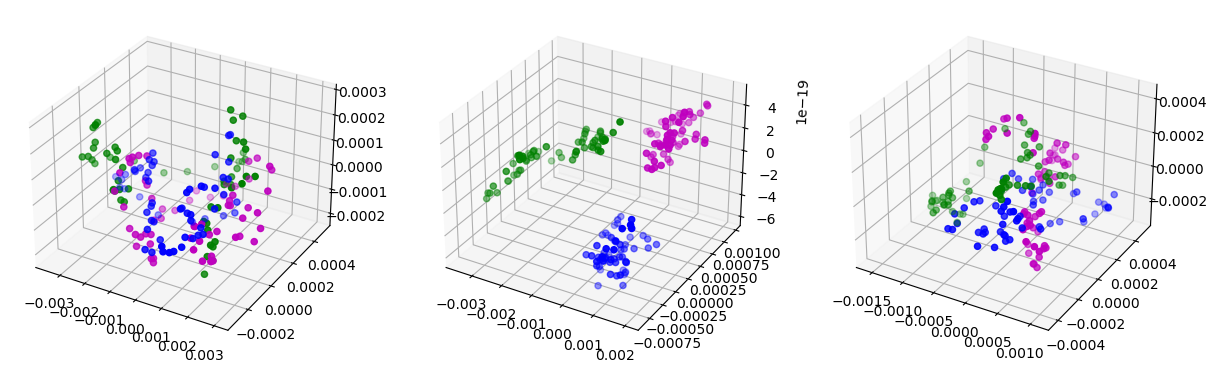

In [28]:
fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(131, projection="3d")
ax.scatter(dpca_comb['t'][0,0], dpca_comb['t'][1,0], dpca_comb['t'][2,0], color='b')
ax.scatter(dpca_comb['t'][0,1], dpca_comb['t'][1,1], dpca_comb['t'][2,1], color='m')
ax.scatter(dpca_comb['t'][0,2], dpca_comb['t'][1,2], dpca_comb['t'][2,2], color='g')

ax = fig.add_subplot(132, projection="3d")
ax.scatter(dpca_comb['s'][0,0], dpca_comb['s'][1,0], dpca_comb['s'][2,0], color='b')
ax.scatter(dpca_comb['s'][0,1], dpca_comb['s'][1,1], dpca_comb['s'][2,1], color='m')
ax.scatter(dpca_comb['s'][0,2], dpca_comb['s'][1,2], dpca_comb['s'][2,2], color='g')

ax = fig.add_subplot(133, projection="3d")
ax.scatter(dpca_comb['st'][0,0], dpca_comb['st'][1,0], dpca_comb['st'][2,0], color='b')
ax.scatter(dpca_comb['st'][0,1], dpca_comb['st'][1,1], dpca_comb['st'][2,1], color='m')
ax.scatter(dpca_comb['st'][0,2], dpca_comb['st'][1,2], dpca_comb['st'][2,2], color='g')

plt.show()

### Perform dPCA on LT, ST, novel, and acquisiion averaged data

In [29]:
all_np = np.concatenate((LT_np, ST_np, novel_np, acq_np), axis=1)
all_np.shape

(215, 4, 60)

In [30]:
dpca = dPCA.dPCA('st', n_components, regularizer=0.01)
dpca.protect = ['t']
dpca_all = dpca.fit_transform(all_np)

3.127060429331892e-06
3.1182224824813274e-05
6.155485327228369e-07


Text(0.5, 0.98, 'Explained cumulative variance')

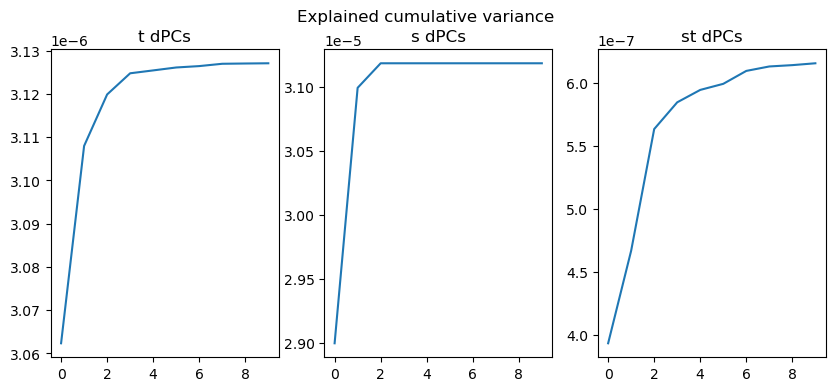

In [31]:
fig = plt.figure(figsize=(10,4))
plt.subplot(131)
plt.plot(np.cumsum(dpca.explained_variance_ratio_['t']))
print(np.sum(dpca.explained_variance_ratio_['t']))
plt.title("t dPCs")

plt.subplot(132)
plt.plot(np.cumsum(dpca.explained_variance_ratio_['s']))
print(np.sum(dpca.explained_variance_ratio_['s']))
plt.title("s dPCs")

plt.subplot(133)
plt.plot(np.cumsum(dpca.explained_variance_ratio_['st']))
print(np.sum(dpca.explained_variance_ratio_['st']))
plt.title("st dPCs")

plt.suptitle("Explained cumulative variance")

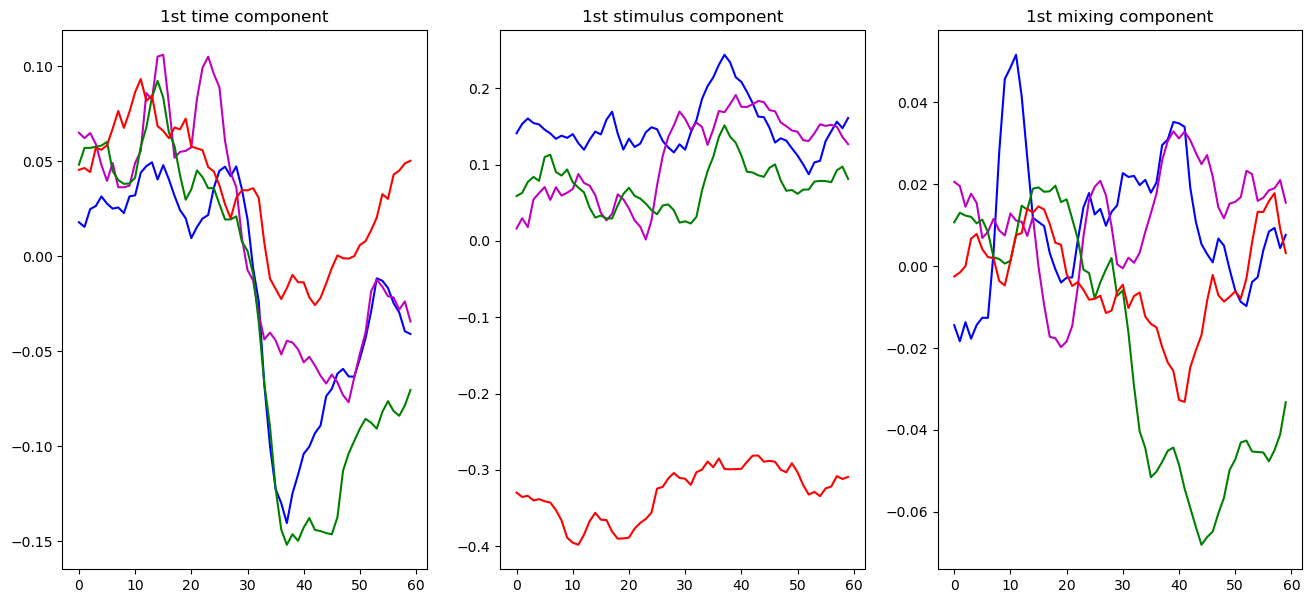

In [32]:
time = np.arange(all_np.shape[2])
S = all_np.shape[1]
colors = ['b', 'm', 'g', 'r']

plt.figure(figsize=(16,7))
plt.subplot(131)

for s in range(S):
    plt.plot(time,dpca_all['t'][0,s], color=colors[s])

plt.title('1st time component')
    
plt.subplot(132)

for s in range(S):
    plt.plot(time,dpca_all['s'][0,s], color=colors[s])
    
plt.title('1st stimulus component')
    
plt.subplot(133)

for s in range(S):
    plt.plot(time,dpca_all['st'][0,s], color=colors[s])
    
plt.title('1st mixing component')
plt.show()

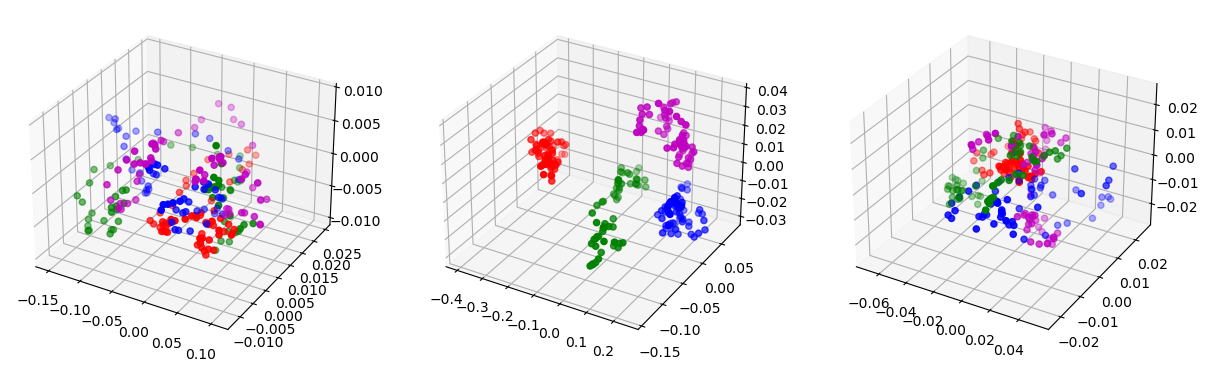

In [33]:
fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(131, projection="3d")
ax.scatter(dpca_all['t'][0,0], dpca_all['t'][1,0], dpca_all['t'][2,0], color='b')
ax.scatter(dpca_all['t'][0,1], dpca_all['t'][1,1], dpca_all['t'][2,1], color='m')
ax.scatter(dpca_all['t'][0,2], dpca_all['t'][1,2], dpca_all['t'][2,2], color='g')
ax.scatter(dpca_all['t'][0,3], dpca_all['t'][1,3], dpca_all['t'][2,3], color='r')

ax = fig.add_subplot(132, projection="3d")
ax.scatter(dpca_all['s'][0,0], dpca_all['s'][1,0], dpca_all['s'][2,0], color='b')
ax.scatter(dpca_all['s'][0,1], dpca_all['s'][1,1], dpca_all['s'][2,1], color='m')
ax.scatter(dpca_all['s'][0,2], dpca_all['s'][1,2], dpca_all['s'][2,2], color='g')
ax.scatter(dpca_all['s'][0,3], dpca_all['s'][1,3], dpca_all['s'][2,3], color='r')

ax = fig.add_subplot(133, projection="3d")
ax.scatter(dpca_all['st'][0,0], dpca_all['st'][1,0], dpca_all['st'][2,0], color='b')
ax.scatter(dpca_all['st'][0,1], dpca_all['st'][1,1], dpca_all['st'][2,1], color='m')
ax.scatter(dpca_all['st'][0,2], dpca_all['st'][1,2], dpca_all['st'][2,2], color='g')
ax.scatter(dpca_all['st'][0,3], dpca_all['st'][1,3], dpca_all['st'][2,3], color='r')

plt.show()

# Phase 3: Constrained 


In [34]:
phase3_collection = unpickle_this('phase3collection.pkl')

In [35]:
# PCA analysis parameters
phase3_analysis = spike.SpikeAnalysis_MultiRecording(
    phase3_collection,
    smoothing_window = 500, #100
    timebin = 250, #50
    ignore_freq = 0.5)

All set to analyze


## dPCA on trialed data

In [36]:
recordings = phase3_analysis.ephyscollection.collection.items()
equalize = 3 ; pre_window = 3 ; post_window = 0
events = ['familiar', 'cagemate', 'novel']
for recording_name, recording in recordings:

    print(recording_name)
    print(recording.subject)

    if (recording.subject != '1.4') or (recording_name != '20230809_143303_1_merged.rec'):
        continue

    print(recording_name)
    print(recording.subject)

    first_event = True
    temp_spike_events = []
    temp_avg_events = []
    for event in events:
        
        print(event)
    
        if first_event:
            event_firing_rates = phase3_analysis.__get_event_firing_rates__(recording, event, equalize, pre_window, post_window)
            event_firing_rates = np.array(event_firing_rates)
            print(event_firing_rates.shape)
            event_averages = np.mean(event_firing_rates, axis = 0) 
            print(event_averages.shape)
            temp_avg_events.append(np.reshape(event_averages, (event_averages.shape[0], 1, event_averages.shape[1])))
            all_event_firing_rates = np.reshape(event_firing_rates, (event_firing_rates.shape[0], event_firing_rates.shape[1], 1, event_firing_rates.shape[2]))
            print(all_event_firing_rates.shape)
            first_event = False
        else:
            event_firing_rates = phase3_analysis.__get_event_firing_rates__(recording, event, equalize, pre_window, post_window)
            event_firing_rates = np.array(event_firing_rates)
            print(event_firing_rates.shape)
            event_averages = np.mean(event_firing_rates, axis = 0) 
            print(event_averages.shape)
            temp_avg_events.append(np.reshape(event_averages, (event_averages.shape[0], 1, event_averages.shape[1])))
            event_firing_rates_reshape = np.reshape(event_firing_rates, (event_firing_rates.shape[0], event_firing_rates.shape[1], 1, event_firing_rates.shape[2]))
            print(event_firing_rates_reshape.shape)
            all_event_firing_rates = np.concatenate((all_event_firing_rates, event_firing_rates_reshape), axis=0)
        print(all_event_firing_rates[:18].shape)
        temp_spike_events.append(all_event_firing_rates[:18])
        # break
    comb_trials = np.concatenate((temp_spike_events[0], temp_spike_events[1], temp_spike_events[2]), axis=2)
    print(comb_trials.shape)
    comb_avgtrials = np.concatenate((temp_avg_events[0], temp_avg_events[1], temp_avg_events[2]), axis=1)
    print(comb_avgtrials.shape)
    break

20230809_103121_1_merged.rec
1.1
20230809_143303_1_merged.rec
1.4
20230809_143303_1_merged.rec
1.4
familiar
(23, 38, 24)
(38, 24)
(23, 38, 1, 24)
(18, 38, 1, 24)
cagemate
(4, 38, 24)
(38, 24)
(4, 38, 1, 24)
(18, 38, 1, 24)
novel
(21, 38, 24)
(38, 24)
(21, 38, 1, 24)
(18, 38, 1, 24)
(18, 38, 3, 24)
(38, 3, 24)


In [37]:
dpca = dPCA.dPCA('st', n_components=5, regularizer='auto')
dpca.protect = ['t']
dpca_comb = dpca.fit_transform(comb_avgtrials, comb_trials)

You chose to determine the regularization parameter automatically. This can
                    take substantial time and grows linearly with the number of crossvalidation
                    folds. The latter can be set by changing self.n_trials (default = 3). Similarly,
                    use self.protect to set the list of axes that are not supposed to get to get shuffled
                    (e.g. upon splitting the data into test- and training, time-points should always
                    be drawn from the same trial, i.e. self.protect = ['t']). This can significantly
                    speed up the code.
Start optimizing regularization.
Starting trial  1 / 3
Starting trial  2 / 3
Starting trial  3 / 3
Optimized regularization, optimal lambda =  0.2689264815224247
Regularization will be fixed; to compute the optimal                    parameter again on the next fit, please                    set opt_regularizer_flag to True.


5.3345404481989946e-08
2.390530895323259e-08
1.845860785281074e-08


Text(0.5, 0.98, 'Explained cumulative variance')

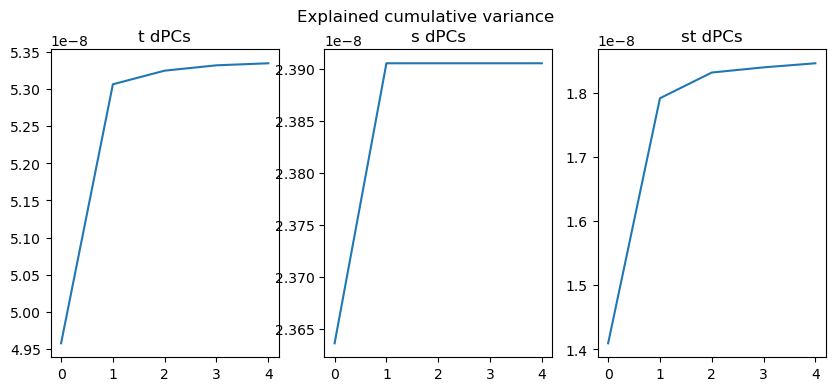

In [38]:
fig = plt.figure(figsize=(10,4))
plt.subplot(131)
plt.plot(np.cumsum(dpca.explained_variance_ratio_['t']))
print(np.sum(dpca.explained_variance_ratio_['t']))
plt.title("t dPCs")

plt.subplot(132)
plt.plot(np.cumsum(dpca.explained_variance_ratio_['s']))
print(np.sum(dpca.explained_variance_ratio_['s']))
plt.title("s dPCs")

plt.subplot(133)
plt.plot(np.cumsum(dpca.explained_variance_ratio_['st']))
print(np.sum(dpca.explained_variance_ratio_['st']))
plt.title("st dPCs")

plt.suptitle("Explained cumulative variance")

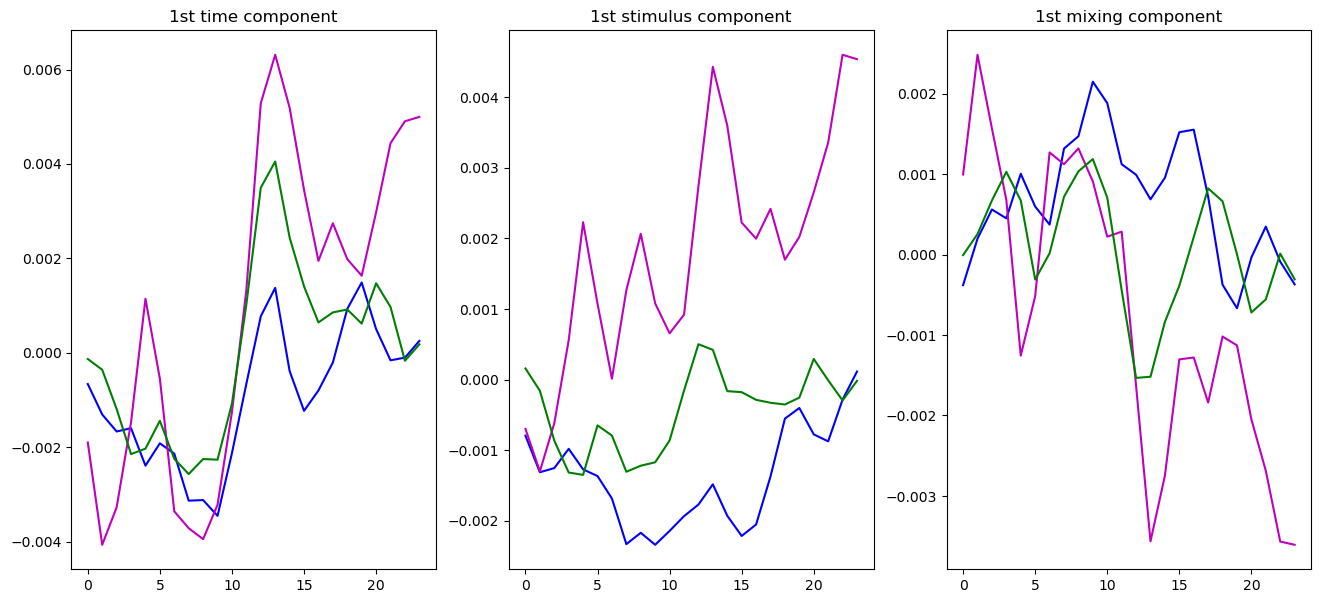

In [39]:
time = np.arange(comb_avgtrials.shape[2])
S = comb_avgtrials.shape[1]
colors = ['b', 'm', 'g']

plt.figure(figsize=(16,7))
plt.subplot(131)

for s in range(S):
    plt.plot(time,dpca_comb['t'][0,s], color=colors[s])

plt.title('1st time component')
    
plt.subplot(132)

for s in range(S):
    plt.plot(time,dpca_comb['s'][0,s], color=colors[s])
    
plt.title('1st stimulus component')
    
plt.subplot(133)

for s in range(S):
    plt.plot(time,dpca_comb['st'][0,s], color=colors[s])
    
plt.title('1st mixing component')
plt.show()

## dPCA on averaged data

### Define familiarity conditions

In [40]:
LT_pc_dict = phase3_analysis.PCA_matrix_generation(equalize=3, pre_window=3, events=['cagemate'])
ST_pc_dict = phase3_analysis.PCA_matrix_generation(equalize=3, pre_window=3, events=['familiar'])
acq_pc_dict = phase3_analysis.PCA_matrix_generation(equalize=3, pre_window=3, events=['acquisition'])
novel_pc_dict = phase3_analysis.PCA_matrix_generation(equalize=3, pre_window=3, events=['novel'])
#dict_keys(['acquisition', 'recall', 'cagemate', 'novel', 'exposure 1', 'exposure 2', 'exposure 3'])
LT_matrix_phase3 = LT_pc_dict['raw data']
ST_matrix_phase3 = ST_pc_dict['raw data']
acq_matrix_phase3 = acq_pc_dict['raw data']
novel_matrix_phase3 = novel_pc_dict['raw data']
#dict_keys(['acquisition', 'cagemate', 'empty', 'novel', 'familiar'])

In [41]:
n_components = 10

### Create dataset

In [42]:
LT_np = LT_matrix_phase3.to_numpy().T
LT_np = np.reshape(LT_np, (LT_np.shape[0], 1, LT_np.shape[1]))

ST_np = ST_matrix_phase3.to_numpy().T
ST_np = np.reshape(ST_np, (ST_np.shape[0], 1, ST_np.shape[1]))

novel_np = novel_matrix_phase3.to_numpy().T
novel_np = np.reshape(novel_np, (novel_np.shape[0], 1, novel_np.shape[1]))

acq_np = acq_matrix_phase3.to_numpy().T
acq_np = np.reshape(acq_np, (acq_np.shape[0], 1, acq_np.shape[1]))


In [43]:
comb_np = np.concatenate((LT_np, ST_np, novel_np), axis=1)
comb_np.shape

(176, 3, 24)

### Perform dPCA

In [44]:
dpca = dPCA.dPCA('st', n_components, regularizer=0.5)
dpca.protect = ['t']
dpca_comb = dpca.fit_transform(comb_np)

3.2339970261994276e-11
3.626911598562265e-11
1.3380139920778305e-11


Text(0.5, 0.98, 'Explained cumulative variance')

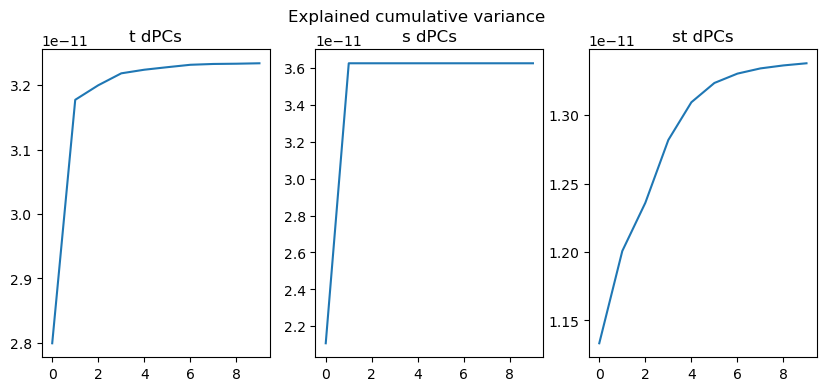

In [45]:
fig = plt.figure(figsize=(10,4))
plt.subplot(131)
plt.plot(np.cumsum(dpca.explained_variance_ratio_['t']))
print(np.sum(dpca.explained_variance_ratio_['t']))
plt.title("t dPCs")

plt.subplot(132)
plt.plot(np.cumsum(dpca.explained_variance_ratio_['s']))
print(np.sum(dpca.explained_variance_ratio_['s']))
plt.title("s dPCs")

plt.subplot(133)
plt.plot(np.cumsum(dpca.explained_variance_ratio_['st']))
print(np.sum(dpca.explained_variance_ratio_['st']))
plt.title("st dPCs")

plt.suptitle("Explained cumulative variance")

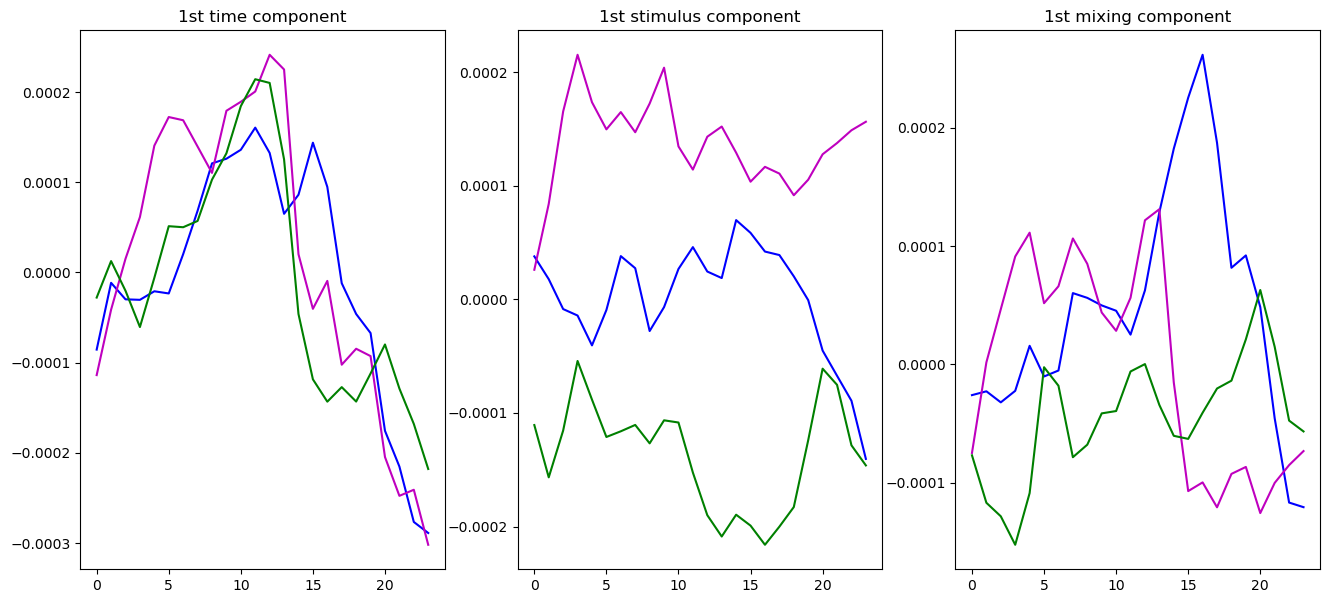

In [46]:
time = np.arange(comb_np.shape[2])
S = comb_np.shape[1]
colors = ['b', 'm', 'g']

plt.figure(figsize=(16,7))
plt.subplot(131)

for s in range(S):
    plt.plot(time,dpca_comb['t'][0,s], color=colors[s])

plt.title('1st time component')
    
plt.subplot(132)

for s in range(S):
    plt.plot(time,dpca_comb['s'][0,s], color=colors[s])
    
plt.title('1st stimulus component')
    
plt.subplot(133)

for s in range(S):
    plt.plot(time,dpca_comb['st'][0,s], color=colors[s])
    
plt.title('1st mixing component')
plt.show()

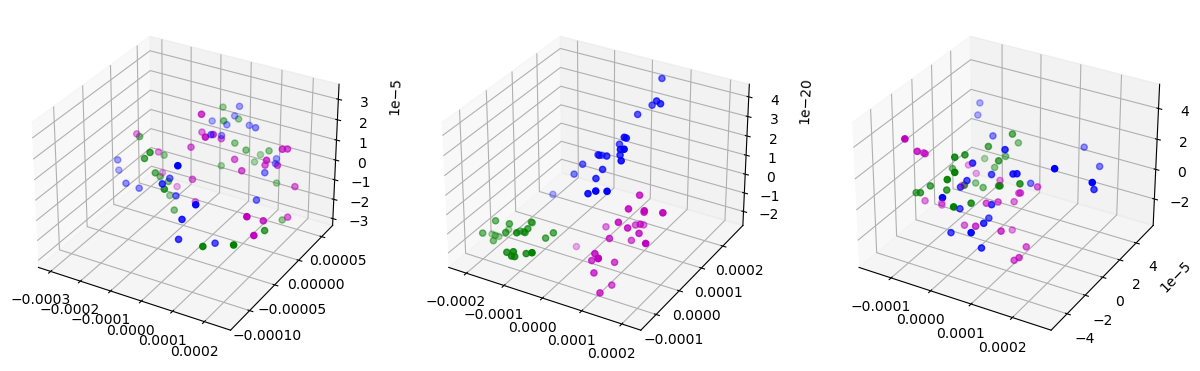

In [47]:
fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(131, projection="3d")
ax.scatter(dpca_comb['t'][0,0], dpca_comb['t'][1,0], dpca_comb['t'][2,0], color='b')
ax.scatter(dpca_comb['t'][0,1], dpca_comb['t'][1,1], dpca_comb['t'][2,1], color='m')
ax.scatter(dpca_comb['t'][0,2], dpca_comb['t'][1,2], dpca_comb['t'][2,2], color='g')

ax = fig.add_subplot(132, projection="3d")
ax.scatter(dpca_comb['s'][0,0], dpca_comb['s'][1,0], dpca_comb['s'][2,0], color='b')
ax.scatter(dpca_comb['s'][0,1], dpca_comb['s'][1,1], dpca_comb['s'][2,1], color='m')
ax.scatter(dpca_comb['s'][0,2], dpca_comb['s'][1,2], dpca_comb['s'][2,2], color='g')

ax = fig.add_subplot(133, projection="3d")
ax.scatter(dpca_comb['st'][0,0], dpca_comb['st'][1,0], dpca_comb['st'][2,0], color='b')
ax.scatter(dpca_comb['st'][0,1], dpca_comb['st'][1,1], dpca_comb['st'][2,1], color='m')
ax.scatter(dpca_comb['st'][0,2], dpca_comb['st'][1,2], dpca_comb['st'][2,2], color='g')

plt.show()

In [48]:
all_np = np.concatenate((LT_np, ST_np, novel_np, acq_np), axis=1)
all_np.shape

(176, 4, 24)

In [49]:
dpca = dPCA.dPCA('st', n_components, regularizer=0.01)
dpca.protect = ['t']
dpca_all = dpca.fit_transform(all_np)

3.0382476748773348e-05
0.0002575490516406133
1.6697729293777224e-05


Text(0.5, 0.98, 'Explained cumulative variance')

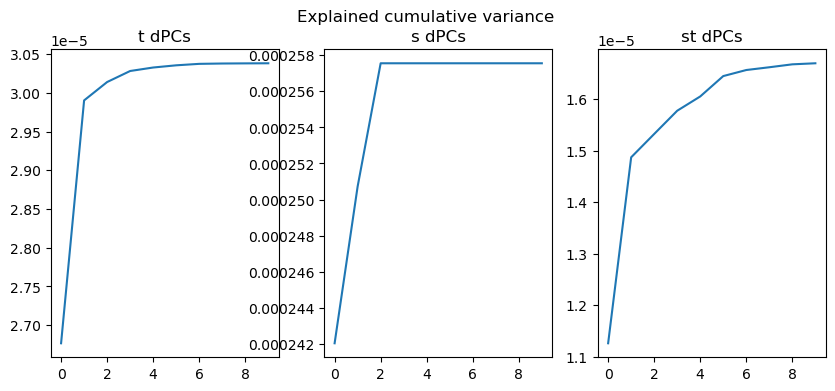

In [50]:
fig = plt.figure(figsize=(10,4))
plt.subplot(131)
plt.plot(np.cumsum(dpca.explained_variance_ratio_['t']))
print(np.sum(dpca.explained_variance_ratio_['t']))
plt.title("t dPCs")

plt.subplot(132)
plt.plot(np.cumsum(dpca.explained_variance_ratio_['s']))
print(np.sum(dpca.explained_variance_ratio_['s']))
plt.title("s dPCs")

plt.subplot(133)
plt.plot(np.cumsum(dpca.explained_variance_ratio_['st']))
print(np.sum(dpca.explained_variance_ratio_['st']))
plt.title("st dPCs")

plt.suptitle("Explained cumulative variance")

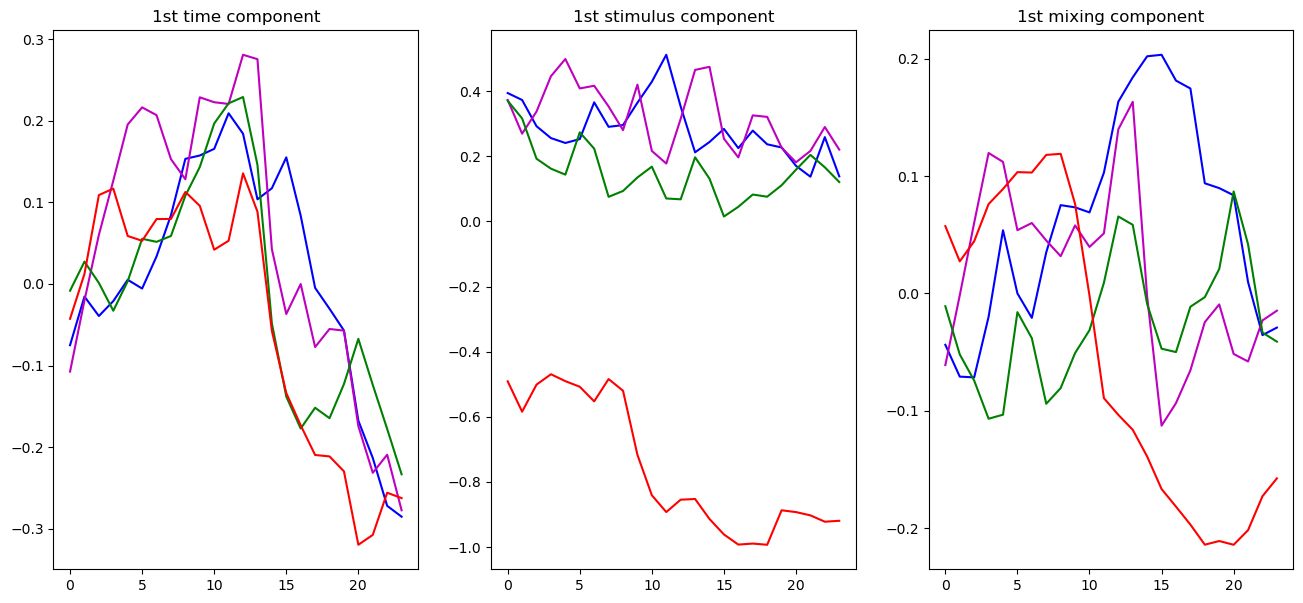

In [51]:
time = np.arange(all_np.shape[2])
S = all_np.shape[1]
colors = ['b', 'm', 'g', 'r']

plt.figure(figsize=(16,7))
plt.subplot(131)

for s in range(S):
    plt.plot(time,dpca_all['t'][0,s], color=colors[s])

plt.title('1st time component')
    
plt.subplot(132)

for s in range(S):
    plt.plot(time,dpca_all['s'][0,s], color=colors[s])
    
plt.title('1st stimulus component')
    
plt.subplot(133)

for s in range(S):
    plt.plot(time,dpca_all['st'][0,s], color=colors[s])
    
plt.title('1st mixing component')
plt.show()

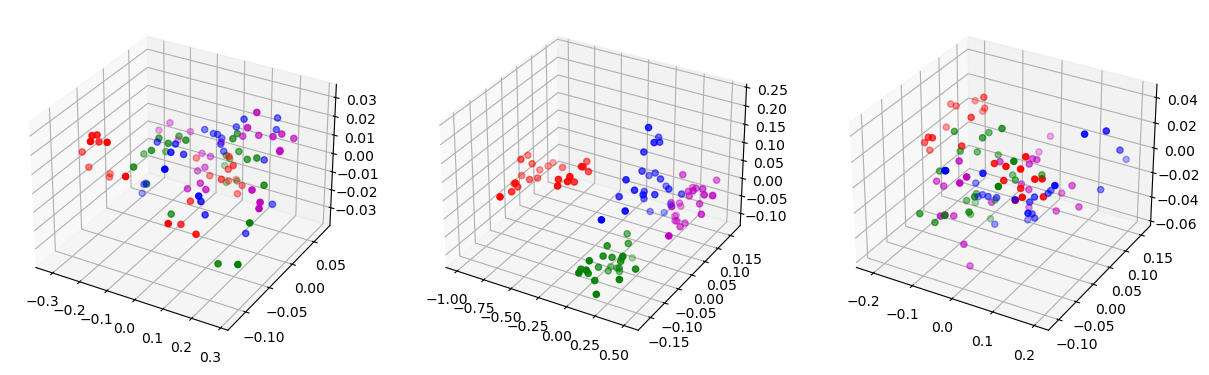

In [52]:
fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(131, projection="3d")
ax.scatter(dpca_all['t'][0,0], dpca_all['t'][1,0], dpca_all['t'][2,0], color='b')
ax.scatter(dpca_all['t'][0,1], dpca_all['t'][1,1], dpca_all['t'][2,1], color='m')
ax.scatter(dpca_all['t'][0,2], dpca_all['t'][1,2], dpca_all['t'][2,2], color='g')
ax.scatter(dpca_all['t'][0,3], dpca_all['t'][1,3], dpca_all['t'][2,3], color='r')

ax = fig.add_subplot(132, projection="3d")
ax.scatter(dpca_all['s'][0,0], dpca_all['s'][1,0], dpca_all['s'][2,0], color='b')
ax.scatter(dpca_all['s'][0,1], dpca_all['s'][1,1], dpca_all['s'][2,1], color='m')
ax.scatter(dpca_all['s'][0,2], dpca_all['s'][1,2], dpca_all['s'][2,2], color='g')
ax.scatter(dpca_all['s'][0,3], dpca_all['s'][1,3], dpca_all['s'][2,3], color='r')

ax = fig.add_subplot(133, projection="3d")
ax.scatter(dpca_all['st'][0,0], dpca_all['st'][1,0], dpca_all['st'][2,0], color='b')
ax.scatter(dpca_all['st'][0,1], dpca_all['st'][1,1], dpca_all['st'][2,1], color='m')
ax.scatter(dpca_all['st'][0,2], dpca_all['st'][1,2], dpca_all['st'][2,2], color='g')
ax.scatter(dpca_all['st'][0,3], dpca_all['st'][1,3], dpca_all['st'][2,3], color='r')

plt.show()